In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Read the data
data_train = pd.read_csv("./ristek-datathon-2023/train.csv")
data_test = pd.read_csv("./ristek-datathon-2023/test.csv")

In [3]:
import requests
from bs4 import BeautifulSoup
import re

class RoadData:
    def __init__(self, id, maxspeed, highway):
        self.id = id
        self.maxspeed = int(maxspeed)
        self.highway = highway

class NodeData:
    def __init__(self, id, lat, lon):
        self.id = id
        self.lat = float(lat)
        self.long = float(lon)

# fetch data for each road
unique_id_jalan = data_train['id_jalan'].unique()
fetch_data_road = dict()
road_fail       = list()
for id_jalan in unique_id_jalan:
    res = requests.get(f'https://www.openstreetmap.org/api/0.6/way/{id_jalan}')
    
    Bs_data = BeautifulSoup(res.text, "xml")

    param_id = id_jalan
    print(param_id, end=", ")

    b_maxspeed = Bs_data.find('tag', {'k':'maxspeed'}) 
    try:
        val = b_maxspeed.get("v")
    except:
        road_fail.append(param_id)
        print()
        continue
    param_maxspeed = re.search(r'\d+', val).group()
    print(param_maxspeed, end=", ")
    
    b_highway = Bs_data.find('tag', {'k':'highway'}) 
    try:
        param_highway = b_highway.get("v")
    except:
        road_fail.append(param_id)
        print()
        continue
    print(param_highway)

    data = RoadData(param_id, param_maxspeed, param_highway)
    fetch_data_road[f"{param_id}"] = data

# fetch data for each point
unique_id_node_1 = data_train['id_titik_mulai'].unique()
unique_id_node_2 = data_train['id_titik_akhir'].unique()
unique_id_node   = np.union1d(unique_id_node_1, unique_id_node_2)

fetch_data_node = dict()
node_fail       = list()
count = 0
for id_node in unique_id_node:
    count += 1
    res = requests.get(f'https://www.openstreetmap.org/api/0.6/node/{id_node}')
    
    Bs_data = BeautifulSoup(res.text, "xml")

    param_id = id_node
    print(count, param_id, end=", ")
    
    b_lat = Bs_data.find('node')
    try:
        param_lat = b_lat.get("lat")
    except:
        node_fail.append(param_id)
        print()
        continue
    print(param_lat, end=", ")

    b_lon = Bs_data.find('node') 
    param_lon = b_lon.get("lon")
    print(param_lon)

    data = NodeData(param_id, param_lat, param_lon)
    fetch_data_node[f"{param_id}"] = data


691007296, 30, trunk
47010584, 30, primary
22932408, 20, secondary
142479648, 20, primary
8504977, 30, primary
50841260, 30, primary
4060819, 20, primary
24704286, 30, primary
4061596, 20, secondary
4004732, 30, trunk
3688059, 30, trunk
66924592, 30, trunk
3691841, 30, trunk
97453767, 20, secondary
4898588, 20, primary
26785612, 20, primary
182210371, 30, trunk
150783571, 30, trunk
40044423, 30, trunk
1210, 30, primary
1 101831, 51.5356116, -0.1470438
2 106201, 51.5276777, -0.1443142
3 106203, 51.5256574, -0.1442502
4 195849, 51.6398113, -0.1802294
5 195850, 51.6390703, -0.1798086
6 195854, 51.6357453, -0.1767753
7 195855, 51.6337930, -0.1759105
8 196019, 51.6326856, -0.1756549
9 196026, 51.6276102, -0.1748049
10 196033, 51.6265808, -0.1755074
11 196034, 51.6265402, -0.1755367
12 196035, 51.6258079, -0.1759228
13 196038, 51.6235299, -0.1764571
14 196039, 51.6226864, -0.1765291
15 196049, 51.6221812, -0.1765521
16 196050, 51.6217870, -0.1765761
17 196051, 51.6209294, -0.1766224
18 19605

In [4]:
# preprocess
# for each id jalan

southmost_point  = dict()
westmost_point   = dict()

for i in unique_id_jalan:
    
    point_list_l   = data_train[data_train['id_jalan'] == i].loc[:,"id_titik_mulai"]
    point_list_r   = data_train[data_train['id_jalan'] == i].loc[:,"id_titik_akhir"]

    southmost_point[f"{i}"]  = point_list_l.iloc[0]
    westmost_point[f"{i}"]   = point_list_r.iloc[0]
    
    cmp_south = point_list_l.iloc[0]
    if (fetch_data_node[f"{southmost_point[f'{i}']}"].lat > fetch_data_node[f"{cmp_south}"].lat):
        southmost_point[f"{i}"] = cmp_south

    cmp_west = point_list_r.iloc[0]
    if (fetch_data_node[f"{westmost_point[f'{i}']}"].long > fetch_data_node[f"{cmp_west}"].long):
        westmost_point[f"{i}"] = cmp_west

    # print(southmost_point, westmost_point)

    # find southmost point
    # find westmost point

    for j in point_list_l:
        try:
            cmp_south = j
            if (fetch_data_node[f"{southmost_point[f'{i}']}"].lat > fetch_data_node[f"{cmp_south}"].lat):
                southmost_point[f"{i}"] = cmp_south

            cmp_west = j
            if (fetch_data_node[f"{westmost_point[f'{i}']}"].long > fetch_data_node[f"{cmp_west}"].long):
                westmost_point[f"{i}"] = cmp_west
        except:
            continue
            
    for j in point_list_r:
        try:
            cmp_south = j
            if (fetch_data_node[f"{southmost_point[f'{i}']}"].lat > fetch_data_node[f"{cmp_south}"].lat):
                southmost_point[f"{i}"] = cmp_south

            cmp_west = j
            if (fetch_data_node[f"{westmost_point[f'{i}']}"].long > fetch_data_node[f"{cmp_west}"].long):
                westmost_point[f"{i}"] = cmp_west
        except:
            continue

    # print("\t", southmost_point, westmost_point)


In [5]:
for i in node_fail:
    # find road_id
    road_id = data_train[data_train['id_titik_mulai'] == i].loc[:, "id_jalan"]
    road_id = road_id.iloc[0]

    # find lowest south
    sp = southmost_point[f"{road_id}"]

    # find lowest west
    wp = westmost_point[f"{road_id}"]

    print(road_id, sp, wp)

    param_id = i
    param_lat = fetch_data_node[f"{sp}"].lat
    param_lon = fetch_data_node[f"{wp}"].long

    print("\t", param_id, param_lat, param_lon)
    data = NodeData(param_id, param_lat, param_lon)
    fetch_data_node[f"{param_id}"] = data

4061596 114269783 114269783
	 227758 51.4491363 -0.1313609
150783571 290017288 290017288
	 227771 51.4494353 -0.1232714
8504977 2378878 2375153
	 2375143 51.5279046 -0.2374632
1210 1701653559 195849
	 1663461749 51.6315762 -0.1802294
1210 1701653559 195849
	 1701556095 51.6315762 -0.1802294
50841260 620849633 620872401
	 5669475346 51.576043 -0.1998938
3688059 299294 6106607129
	 6205314505 51.449898 -0.2439392


In [6]:
print(fetch_data_node['21390008'].long)

-0.1611764


In [7]:
unique_id_node_1 = data_train['id_titik_mulai'].unique()
unique_id_node_2 = data_train['id_titik_akhir'].unique()


# Loop through each unique 'id_jalan'
for id_node in unique_id_node_1:
    # Get the row index for the current 'id_jalan'
    row_index = data_train[data_train['id_titik_mulai'] == id_node].index

    # Get the specified values for 'maxspeed' and 'highway' from the dictionary
    lat_awal = fetch_data_node[f"{id_node}"].lat
    long_awal = fetch_data_node[f"{id_node}"].long

    # Convert maxspeed from mph to km/h and store it in a new column 'maxspeed_km_jam'
    data_train.loc[row_index, 'lat_titik_awal'] = lat_awal

    # Update the 'highway' column in data_train using .loc
    data_train.loc[row_index, 'long_titik_awal'] = long_awal

# Loop through each unique 'id_jalan'
for id_node in unique_id_node_2:
    # Get the row index for the current 'id_jalan'
    row_index = data_train[data_train['id_titik_akhir'] == id_node].index

    # Get the specified values for 'maxspeed' and 'highway' from the dictionary
    lat_akhir = fetch_data_node[f"{id_node}"].lat
    long_akhir = fetch_data_node[f"{id_node}"].long

    # Convert maxspeed from mph to km/h and store it in a new column 'maxspeed_km_jam'
    data_train.loc[row_index, 'lat_titik_akhir'] = lat_akhir

    # Update the 'highway' column in data_train using .loc
    data_train.loc[row_index, 'long_titik_akhir'] = long_akhir

In [8]:
data_train.head()

,waktu_setempat,id_jalan,id_titik_mulai,id_titik_akhir,rerata_kecepatan,lat_titik_awal,long_titik_awal,lat_titik_akhir,long_titik_akhir
0,2020-02-01 01:00:00+00:00,691007296,21390008,1425033102,29.126,51.434928,-0.161176,51.434975,-0.161090
1,2020-02-01 01:00:00+00:00,47010584,1677092762,579493410,46.576,51.623990,-0.176398,51.623811,-0.176424
2,2020-02-01 01:00:00+00:00,22932408,26486694,1930267566,36.587,51.452530,-0.152437,51.452749,-0.151896
3,2020-02-01 01:00:00+00:00,142479648,1111592522,3775231113,34.063,51.465851,-0.154188,51.465654,-0.155334
4,2020-02-01 01:00:00+00:00,8504977,5940503398,5940503394,38.336,51.530289,-0.228343,51.530197,-0.227949


In [9]:
unique_id_node_1 = data_test['id_titik_mulai'].unique()
unique_id_node_2 = data_test['id_titik_akhir'].unique()
unique_id_jalan = data_test['id_jalan'].unique()

# Loop through each unique 'id_jalan'
for id_node in unique_id_node_1:
    # Get the row index for the current 'id_jalan'
    row_index = data_test[data_test['id_titik_mulai'] == id_node].index

    # Get the specified values for 'maxspeed' and 'highway' from the dictionary
    lat_awal = fetch_data_node[f"{id_node}"].lat
    long_awal = fetch_data_node[f"{id_node}"].long

    # Convert maxspeed from mph to km/h and store it in a new column 'maxspeed_km_jam'
    data_test.loc[row_index, 'lat_titik_awal'] = lat_awal

    # Update the 'highway' column in data_train using .loc
    data_test.loc[row_index, 'long_titik_awal'] = long_awal

# Loop through each unique 'id_jalan'
for id_node in unique_id_node_2:
    # Get the row index for the current 'id_jalan'
    row_index = data_test[data_test['id_titik_akhir'] == id_node].index

    # Get the specified values for 'maxspeed' and 'highway' from the dictionary
    lat_awal = fetch_data_node[f"{id_node}"].lat
    long_awal = fetch_data_node[f"{id_node}"].long

    # Convert maxspeed from mph to km/h and store it in a new column 'maxspeed_km_jam'
    data_test.loc[row_index, 'lat_titik_akhir'] = lat_awal

    # Update the 'highway' column in data_train using .loc
    data_test.loc[row_index, 'long_titik_akhir'] = long_awal

In [10]:
data_test.head()

,id,waktu_setempat,id_jalan,id_titik_mulai,id_titik_akhir,lat_titik_awal,long_titik_awal,lat_titik_akhir,long_titik_akhir
0,0,2020-02-23 00:00:00+00:00,4004732,32046542,6454026544,51.465182,-0.255240,51.465204,-0.254595
1,1,2020-02-23 00:00:00+00:00,182210371,1314925464,1314925496,51.458973,-0.141882,51.459254,-0.141646
2,2,2020-02-23 00:00:00+00:00,22932408,1482086782,26481020,51.449437,-0.160688,51.449295,-0.161060
3,3,2020-02-23 00:00:00+00:00,182210371,3892883,267337489,51.457325,-0.143228,51.457466,-0.143110
4,4,2020-02-23 00:00:00+00:00,66924592,266041030,2592978110,51.467314,-0.112842,51.466309,-0.113371


In [12]:
# Get the unique values of 'id_jalan'
unique_id_jalan = data_train['id_jalan'].unique()

# Dictionary to store the specified values for 'maxspeed' and 'highway' based on 'id_jalan'
id_jalan_values = {
    691007296: {'maxspeed': 30, 'highway': 'trunk'},
    47010584: {'maxspeed': 30, 'highway': 'primary'},
    22932408: {'maxspeed': 20, 'highway': 'secondary'},
    142479648: {'maxspeed': 20, 'highway': 'primary'},
    8504977: {'maxspeed': 30, 'highway': 'primary'},
    50841260: {'maxspeed': 30, 'highway': 'primary'},
    4060819: {'maxspeed': 20, 'highway': 'primary'},
    24704286: {'maxspeed': 30, 'highway': 'primary'},
    4061596: {'maxspeed': 20, 'highway': 'secondary'},
    4004732: {'maxspeed': 30, 'highway': 'trunk'},
    3688059: {'maxspeed': 30, 'highway': 'trunk'},
    66924592: {'maxspeed': 30, 'highway': 'trunk'},
    3691841: {'maxspeed': 30, 'highway': 'trunk'},
    97453767: {'maxspeed': 20, 'highway': 'secondary'},
    4898588: {'maxspeed': 20, 'highway': 'primary'},
    26785612: {'maxspeed': 20, 'highway': 'primary'},
    182210371: {'maxspeed': 30, 'highway': 'trunk'},
    150783571: {'maxspeed': 30, 'highway': 'trunk'},
    40044423: {'maxspeed': 30, 'highway': 'trunk'},
    1210: {'maxspeed': 30, 'highway': 'primary'},
    # Add more id_jalan values and their corresponding maxspeed and highway here
}

# Loop through each unique 'id_jalan'
for id_jalan in unique_id_jalan:
    # Get the row index for the current 'id_jalan'
    row_index = data_train[data_train['id_jalan'] == id_jalan].index

    # Get the specified values for 'maxspeed' and 'highway' from the dictionary
    maxspeed_value_mph = id_jalan_values.get(id_jalan, {}).get('maxspeed')
    highway_value = id_jalan_values.get(id_jalan, {}).get('highway')

    # Convert maxspeed from mph to km/h and store it in a new column 'maxspeed_km_jam'
    maxspeed_value_kmph = maxspeed_value_mph * 1.60934
    data_train.loc[row_index, 'maxspeed_km_jam'] = maxspeed_value_kmph

    # Update the 'highway' column in data_train using .loc
    data_train.loc[row_index, 'highway'] = highway_value


# Print the updated DataFrame
data_train.head()

,waktu_setempat,id_jalan,id_titik_mulai,id_titik_akhir,rerata_kecepatan,lat_titik_awal,long_titik_awal,lat_titik_akhir,long_titik_akhir,maxspeed_km_jam,highway
0,2020-02-01 01:00:00+00:00,691007296,21390008,1425033102,29.126,51.434928,-0.161176,51.434975,-0.161090,48.2802,trunk
1,2020-02-01 01:00:00+00:00,47010584,1677092762,579493410,46.576,51.623990,-0.176398,51.623811,-0.176424,48.2802,primary
2,2020-02-01 01:00:00+00:00,22932408,26486694,1930267566,36.587,51.452530,-0.152437,51.452749,-0.151896,32.1868,secondary
3,2020-02-01 01:00:00+00:00,142479648,1111592522,3775231113,34.063,51.465851,-0.154188,51.465654,-0.155334,32.1868,primary
4,2020-02-01 01:00:00+00:00,8504977,5940503398,5940503394,38.336,51.530289,-0.228343,51.530197,-0.227949,48.2802,primary


In [13]:
# Get the unique values of 'id_jalan' in the test data
unique_id_jalan_test = data_test['id_jalan'].unique()

# Dictionary to store the specified values for 'maxspeed' and 'highway' based on 'id_jalan'
id_jalan_values = {
    691007296: {'maxspeed': 30, 'highway': 'trunk'},
    47010584: {'maxspeed': 30, 'highway': 'primary'},
    22932408: {'maxspeed': 20, 'highway': 'secondary'},
    142479648: {'maxspeed': 20, 'highway': 'primary'},
    8504977: {'maxspeed': 30, 'highway': 'primary'},
    50841260: {'maxspeed': 30, 'highway': 'primary'},
    4060819: {'maxspeed': 20, 'highway': 'primary'},
    24704286: {'maxspeed': 30, 'highway': 'primary'},
    4061596: {'maxspeed': 20, 'highway': 'secondary'},
    4004732: {'maxspeed': 30, 'highway': 'trunk'},
    3688059: {'maxspeed': 30, 'highway': 'trunk'},
    66924592: {'maxspeed': 30, 'highway': 'trunk'},
    3691841: {'maxspeed': 30, 'highway': 'trunk'},
    97453767: {'maxspeed': 20, 'highway': 'secondary'},
    4898588: {'maxspeed': 20, 'highway': 'primary'},
    26785612: {'maxspeed': 20, 'highway': 'primary'},
    182210371: {'maxspeed': 30, 'highway': 'trunk'},
    150783571: {'maxspeed': 30, 'highway': 'trunk'},
    40044423: {'maxspeed': 30, 'highway': 'trunk'},
    1210: {'maxspeed': 30, 'highway': 'primary'},
    # Add more id_jalan values and their corresponding maxspeed and highway here
}

# Loop through each unique 'id_jalan' in the test data
for id_jalan in unique_id_jalan_test:
    # Get the row index for the current 'id_jalan'
    row_index_test = data_test[data_test['id_jalan'] == id_jalan].index

    # Get the specified values for 'maxspeed' and 'highway' from the dictionary
    maxspeed_value_mph = id_jalan_values.get(id_jalan, {}).get('maxspeed')
    highway_value = id_jalan_values.get(id_jalan, {}).get('highway')

    # Convert maxspeed from mph to km/h and store it in a new column 'maxspeed_km_jam'
    maxspeed_value_kmph = maxspeed_value_mph * 1.60934
    data_test.loc[row_index_test, 'maxspeed_km_jam'] = maxspeed_value_kmph

    # Update the 'highway' column in data_test using .loc
    data_test.loc[row_index_test, 'highway'] = highway_value

# Print the updated DataFrame
data_test.head()


,id,waktu_setempat,id_jalan,id_titik_mulai,id_titik_akhir,lat_titik_awal,long_titik_awal,lat_titik_akhir,long_titik_akhir,maxspeed_km_jam,highway
0,0,2020-02-23 00:00:00+00:00,4004732,32046542,6454026544,51.465182,-0.255240,51.465204,-0.254595,48.2802,trunk
1,1,2020-02-23 00:00:00+00:00,182210371,1314925464,1314925496,51.458973,-0.141882,51.459254,-0.141646,48.2802,trunk
2,2,2020-02-23 00:00:00+00:00,22932408,1482086782,26481020,51.449437,-0.160688,51.449295,-0.161060,32.1868,secondary
3,3,2020-02-23 00:00:00+00:00,182210371,3892883,267337489,51.457325,-0.143228,51.457466,-0.143110,48.2802,trunk
4,4,2020-02-23 00:00:00+00:00,66924592,266041030,2592978110,51.467314,-0.112842,51.466309,-0.113371,48.2802,trunk


In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Preprocessing for training data
data_train['waktu_setempat'] = pd.to_datetime(data_train['waktu_setempat'])
data_train['year'] = data_train['waktu_setempat'].dt.year
data_train['month'] = data_train['waktu_setempat'].dt.month
data_train['day'] = data_train['waktu_setempat'].dt.day
data_train['day_of_week'] = data_train['waktu_setempat'].dt.dayofweek  # Monday=0, Sunday=6
data_train['day_of_month'] = data_train['waktu_setempat'].dt.day
data_train['hour'] = data_train['waktu_setempat'].dt.hour
data_train['week_of_year'] = data_train['waktu_setempat'].dt.isocalendar().week
data_train.set_index("waktu_setempat", inplace=True)
data_train['highway'] = data_train['highway'].astype('category')
data_train['maxspeed_km_jam'] = data_train['maxspeed_km_jam'].astype('category')
data_train['week_of_year'] = data_train['week_of_year'].astype(int)
data_train['day_of_week'] = data_train['day_of_week'].astype('category')

# Perform label encoding for 'highway'
label_encoder_highway = LabelEncoder()
data_train['highway_encoded'] = label_encoder_highway.fit_transform(data_train['highway'])
data_train.drop(['highway'], axis=1, inplace=True)

# Perform label encoding for 'maxspeed_km_jam'
label_encoder_maxspeed = LabelEncoder()
data_train['maxspeed_km_jam_encoded'] = label_encoder_maxspeed.fit_transform(data_train['maxspeed_km_jam'])
data_train.drop(['maxspeed_km_jam'], axis=1, inplace=True)

# Perform one-hot encoding for categorical columns
categorical_columns = ['id_jalan', 'month', 'day_of_week']
data_train_encoded = pd.get_dummies(data_train, columns=categorical_columns)

# Create features (X) and target variable (y) for training set
input_features = list(data_train_encoded.columns)
input_features.remove('rerata_kecepatan')  # Remove the target variable
target_variable = 'rerata_kecepatan'
X_train = data_train_encoded[input_features]
y_train = data_train_encoded[target_variable]

# Preprocessing for testing data
data_test['waktu_setempat'] = pd.to_datetime(data_test['waktu_setempat'])
data_test['year'] = data_test['waktu_setempat'].dt.year
data_test['month'] = data_test['waktu_setempat'].dt.month
data_test['day'] = data_test['waktu_setempat'].dt.day
data_test['day_of_week'] = data_test['waktu_setempat'].dt.dayofweek  # Monday=0, Sunday=6
data_test['day_of_month'] = data_test['waktu_setempat'].dt.day
data_test['hour'] = data_test['waktu_setempat'].dt.hour
data_test['week_of_year'] = data_test['waktu_setempat'].dt.isocalendar().week
data_test.set_index("waktu_setempat", inplace=True)
data_test['highway'] = data_test['highway'].astype('category')
data_test['maxspeed_km_jam'] = data_test['maxspeed_km_jam'].astype('category')
data_test['week_of_year'] = data_test['week_of_year'].astype(int)
data_test['day_of_week'] = data_test['day_of_week'].astype('category')

# Perform label encoding for 'highway' and 'maxspeed_km_jam' in testing data
data_test['highway_encoded'] = label_encoder_highway.transform(data_test['highway'])
data_test.drop(['highway'], axis=1, inplace=True)

data_test['maxspeed_km_jam_encoded'] = label_encoder_maxspeed.transform(data_test['maxspeed_km_jam'])
data_test.drop(['maxspeed_km_jam'], axis=1, inplace=True)

# Perform one-hot encoding for categorical columns in testing data
data_test_encoded = pd.get_dummies(data_test, columns=categorical_columns)

# Create features (X) for testing set
X_test = data_test_encoded[input_features]


In [15]:
X_train.head()

,id_titik_mulai,id_titik_akhir,lat_titik_awal,long_titik_awal,lat_titik_akhir,long_titik_akhir,year,day,day_of_month,hour,...,id_jalan_182210371,id_jalan_691007296,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
waktu_setempat,,,,,,,,,,,,,,,,,,,,,
2020-02-01 01:00:00+00:00,21390008,1425033102,51.434928,-0.161176,51.434975,-0.161090,2020,1,1,1,...,False,True,True,False,False,False,False,False,True,False
2020-02-01 01:00:00+00:00,1677092762,579493410,51.623990,-0.176398,51.623811,-0.176424,2020,1,1,1,...,False,False,True,False,False,False,False,False,True,False
2020-02-01 01:00:00+00:00,26486694,1930267566,51.452530,-0.152437,51.452749,-0.151896,2020,1,1,1,...,False,False,True,False,False,False,False,False,True,False
2020-02-01 01:00:00+00:00,1111592522,3775231113,51.465851,-0.154188,51.465654,-0.155334,2020,1,1,1,...,False,False,True,False,False,False,False,False,True,False
2020-02-01 01:00:00+00:00,5940503398,5940503394,51.530289,-0.228343,51.530197,-0.227949,2020,1,1,1,...,False,False,True,False,False,False,False,False,True,False


In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define hyperparameter grid
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': randint(3, 10),
    'min_child_weight': [1, 5, 10],
    'subsample': uniform(0.6, 0.4),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1]
}

# Create and fit RandomizedSearchCV
model = XGBRegressor(random_state=8567)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_model.fit(X_train, y_train) 
# Predict on training data
y_fit = pd.DataFrame(best_model.predict(X_train), index=X_train.index, columns=[target_variable])


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [17]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)

print((f"Train RMSE: {train_rmse:.2f}"))

Train RMSE: 2.99


In [18]:
print(y_fit)

                           rerata_kecepatan
waktu_setempat                             
2020-02-01 01:00:00+00:00         30.124926
2020-02-01 01:00:00+00:00         44.081711
2020-02-01 01:00:00+00:00         37.133240
2020-02-01 01:00:00+00:00         35.736492
2020-02-01 01:00:00+00:00         39.624218
...                                     ...
2020-02-22 23:00:00+00:00         40.055275
2020-02-22 23:00:00+00:00         45.710888
2020-02-22 23:00:00+00:00         39.455517
2020-02-22 23:00:00+00:00         33.723274
2020-02-22 23:00:00+00:00         39.339504

[398648 rows x 1 columns]


In [19]:
X_test.head()

,id_titik_mulai,id_titik_akhir,lat_titik_awal,long_titik_awal,lat_titik_akhir,long_titik_akhir,year,day,day_of_month,hour,...,id_jalan_182210371,id_jalan_691007296,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
waktu_setempat,,,,,,,,,,,,,,,,,,,,,
2020-02-23 00:00:00+00:00,32046542,6454026544,51.465182,-0.255240,51.465204,-0.254595,2020,23,23,0,...,False,False,True,False,False,False,False,False,False,True
2020-02-23 00:00:00+00:00,1314925464,1314925496,51.458973,-0.141882,51.459254,-0.141646,2020,23,23,0,...,True,False,True,False,False,False,False,False,False,True
2020-02-23 00:00:00+00:00,1482086782,26481020,51.449437,-0.160688,51.449295,-0.161060,2020,23,23,0,...,False,False,True,False,False,False,False,False,False,True
2020-02-23 00:00:00+00:00,3892883,267337489,51.457325,-0.143228,51.457466,-0.143110,2020,23,23,0,...,True,False,True,False,False,False,False,False,False,True
2020-02-23 00:00:00+00:00,266041030,2592978110,51.467314,-0.112842,51.466309,-0.113371,2020,23,23,0,...,False,False,True,False,False,False,False,False,False,True


In [21]:
best_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=443, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=8567, ...)

In [22]:
y_pred = best_model.predict(X_test)

In [23]:
print(y_pred)

[42.08882  36.981422 37.559082 ... 41.87673  34.440937 44.850952]


In [24]:
# Prepare the submission file
submission_df = pd.DataFrame({'id': data_test['id'], 'rerata_kecepatan': y_pred})
submission_df.to_csv('/mnt/d/Projekt/datathon/ristek-datathon-2023/sub_10-8-2.csv', index=False)

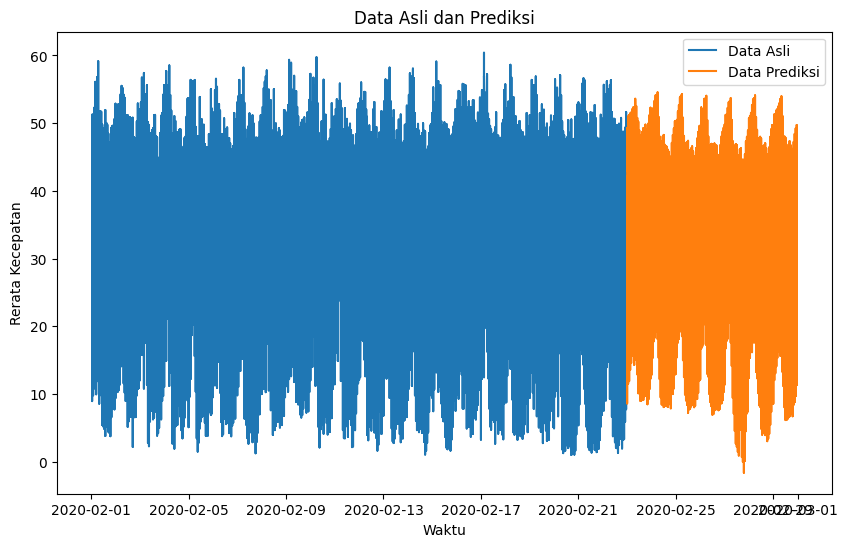

In [25]:
import matplotlib.pyplot as plt
# Plot data asli dan prediksi
plt.figure(figsize=(10, 6))
plt.plot(data_train.index, data_train[target_variable], label='Data Asli')
plt.plot(data_test.index, y_pred, label='Data Prediksi')
plt.xlabel('Waktu')
plt.ylabel('Rerata Kecepatan')
plt.title('Data Asli dan Prediksi')
plt.legend()
plt.show()